# introduction
This file is used to train an image segmentation model to detect plant diseases in order to be used in an application to detect plant health in real-time and classify what type of disease is it inflicted with if any.

## Dataset used
The dataset used is the PlantVillage Dataset from Kaggle. The dataset can be found [here](https://www.kaggle.com/datasets/alexisbcook/plantvillage).

# 1. Dataset
In this section, we will create:
1. the Dataset class.
2. the DataLoader class.

And we will explore the dataset and visualize each class size in training, validation and test sets.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
import cv2

## 1.1. Creating a transformation pipeline
The pipeline consists of the following transformations:
1. Resize.
2. RandomCrop.
3. Rotate limit of 40 degrees.
4. HorizontalFlip.
5. VerticalFlip.
6. RGBShift.
7. OneOf: Blur or ColorJitter.
8. Normalize the images.
9. Converting to tensor via ToTensorV2.

In [2]:
# Creating a transformation pipeline using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.1),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=25,
        p=0.3, border_mode=0
    ),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

c:\Users\basel\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 1.2. Dataset Class & DataLoaders for the Dataset

In [3]:
import os
from pathlib import Path

In [4]:
# Creating a custom dataset loader for the PlantVillage dataset
class PlantVillageSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get all image paths
        self.image_paths = sorted(list(Path(image_dir).rglob("*.jpg")))
        self.mask_paths = []
        valid_image_paths = []
        
        print(f"Found {len(self.image_paths)} images, checking for corresponding masks...")
        
        for img_path in self.image_paths:
            # build corresponding mask path
            rel_path = img_path.relative_to(image_dir)
            mask_path = Path(mask_dir) / rel_path.parent / f"{img_path.stem}_final_masked.jpg"
            
            if mask_path.exists():
                self.mask_paths.append(mask_path)
                valid_image_paths.append(img_path)
            else:
                print(f"Mask missing for: {img_path}")
        
        self.image_paths = valid_image_paths
        print(f"Final dataset size: {len(self.image_paths)} images with masks")
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        mask = (mask > 0).float()
        return image, mask

- Adding the dataset file locations

In [5]:
dataset_loc = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data"
color_full_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\color"
segmented_images_dir = "G:\Work Projects\AI & ML Projects\Plants-Disease-Detection---Identification\data\segmented"

In [6]:
# Add class instances of Train, Validation, Test split datasets
train_dataset = PlantVillageSegmentationDataset(
    image_dir=os.path.join(color_full_images_dir, 'train'),
    mask_dir=os.path.join(segmented_images_dir, 'train'),
    transform=transform
)

val_dataset = PlantVillageSegmentationDataset(
    image_dir=os.path.join(color_full_images_dir, 'valid'),
    mask_dir=os.path.join(segmented_images_dir, 'valid'),
    transform=transform
)

test_dataset = PlantVillageSegmentationDataset(
    image_dir=os.path.join(color_full_images_dir, 'test'),
    mask_dir=os.path.join(segmented_images_dir, 'test'),
    transform=transform
)

# Testing for image size
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Found 42473 images, checking for corresponding masks...
Final dataset size: 42473 images with masks
Found 5296 images, checking for corresponding masks...
Final dataset size: 5296 images with masks
Found 5338 images, checking for corresponding masks...
Final dataset size: 5338 images with masks
Train Dataset Size: 42473
Validation Dataset Size: 5296
Test Dataset Size: 5338


In [ ]:
# Building DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [8]:
# Test the dataset first without DataLoader
print("Testing dataset access...")
for i in range(min(3, len(test_dataset))):
    try:
        image, mask = test_dataset[i]
        print(f"Sample {i}: image shape {image.shape}, mask shape {mask.shape}")
    except Exception as e:
        print(f"Error loading sample {i}: {e}")

Testing dataset access...
Sample 0: image shape torch.Size([3, 256, 256]), mask shape torch.Size([256, 256])
Sample 1: image shape torch.Size([3, 256, 256]), mask shape torch.Size([256, 256])
Sample 2: image shape torch.Size([3, 256, 256]), mask shape torch.Size([256, 256])


In [9]:
# Testing DataLoaders
for images, masks in test_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break

Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 256, 256])


## 2. Model Building
In this second main section, we will build the Image Segmentation model (U-net) first, then build the classification model (ResNet18) and finally combine them together to form a complete model that segments the image first, then classifies it depending on all the classes present in the dataset.

In [10]:
import torch
import torch.nn as nn

## 2.1. Building the Image Segmentation Model (U-net)

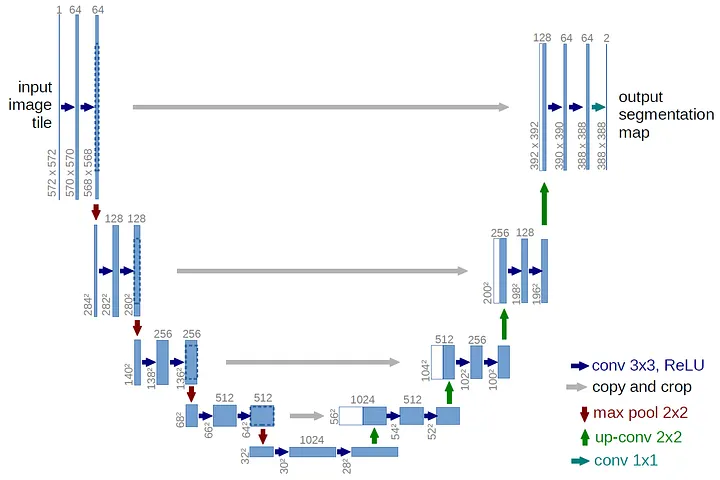

In [18]:
# Double-conv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [32]:
# Downsampling block
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

In [20]:
# Upsampling block
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
# The U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Encoder blocks (downsampling phase)
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Middle Phase (Bottleneck)
        self.middle = DoubleConv(512, 1024)

        # Upsample phase
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        down_1, p1 = self.down1(x)
        down_2, p2 = self.down2(p1)
        down_3, p3 = self.down3(p2)
        down_4, p4 = self.down4(p3)
        middle = self.middle(p4)
        up_1 = self.up1(middle, down_4)
        up_2 = self.up2(up_1, down_3)
        up_3 = self.up3(up_2, down_2)
        up_4 = self.up4(up_3, down_1)
        out = self.out(up_4)
        return torch.sigmoid(out)

## 2.2. Initializing the Image Segmentation Model

In [35]:
from torchsummary import summary

In [37]:
# Intialize the U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segm_model = UNet(3, 1).to(device)

# Print the model summary
print(f"Model Device: {device}")
print(f"Model Summary: {summary(segm_model, (3, 256, 256))}")

Model Device: cuda
Layer (type:depth-idx)                   Output Shape              Param #
├─DownSample: 1-1                        [-1, 64, 256, 256]        --
|    └─DoubleConv: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 64, 256, 256]        38,976
|    └─MaxPool2d: 2-2                    [-1, 64, 128, 128]        --
├─DownSample: 1-2                        [-1, 128, 128, 128]       --
|    └─DoubleConv: 2-3                   [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2              [-1, 128, 128, 128]       221,952
|    └─MaxPool2d: 2-4                    [-1, 128, 64, 64]         --
├─DownSample: 1-3                        [-1, 256, 64, 64]         --
|    └─DoubleConv: 2-5                   [-1, 256, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 256, 64, 64]         886,272
|    └─MaxPool2d: 2-6                    [-1, 256, 32, 32]         --
├─DownSample: 1-4                        [-1, 512, 3